<h1 style="color:rgb(0,120,170)">Neural Networks and Deep Learning</h1>
<h2 style="color:rgb(0,120,170)"> Predictive Analysis - Image Processing</h2>


#### Classify handwritten digits using the famous MNIST data

The goal in this task is to take an image of a handwritten single digit, and determine what that digit is.  

The data for this competition were taken from the MNIST dataset. The MNIST ("Modified National Institute of Standards and Technology") dataset is a classic within the Machine Learning community that has been extensively studied.  More detail about the dataset, including Machine Learning algorithms that have been tried on it and their levels of success, can be found at http://yann.lecun.com/exdb/mnist/index.html.  

In [1]:
import os
import sys
import time
import glob
import math
import random
import pickle
import pylab
from zipfile import ZipFile

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib.font_manager import FontProperties
from matplotlib import pyplot

from sklearn.model_selection import KFold
from sklearn import model_selection
from sklearn.decomposition import PCA

import tensorflow as tf

%matplotlib inline
#matplotlib.rcdefaults()
#matplotlib.verbose.set_level('silent')
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

from IPython.display import Image
from IPython.core.display import HTML

2022-02-12 01:44:58.149758: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-02-12 01:44:58.149790: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
print(tf.__version__)

2.8.0


In [3]:
datapath = "../../../data/"
outputs = "../../../data/"

In [4]:
# read training data from CSV file 

with ZipFile(os.path.join(datapath, 'kaggle_digits_train.zip'), 'r') as myzip:
    with myzip.open('kaggle_digits_train.csv') as myfile:
        train_data = pd.read_csv(myfile)
        
with ZipFile(os.path.join(datapath, 'kaggle_digits_test.zip'), 'r') as myzip:
    with myzip.open('kaggle_digits_test.csv') as myfile:
        test_data = pd.read_csv(myfile)

print('data({0[0]},{0[1]})'.format(train_data.shape))
train_data.head()

data(42000,785)


,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Every image is a "stretched" array of pixel values.  
In this case it's 784 pixels => 28 * 28 px  

In [5]:
images = train_data.iloc[:,1:].values
images = images.astype(np.float)

# convert from [0:255] => [0.0:1.0]
images = np.multiply(images, 1.0 / 255.0)

print('images numpy array have shape: ({0[0]},{0[1]})'.format(images.shape))

/tmp/ipykernel_148044/2644476569.py:2: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  images = images.astype(np.float)


images numpy array have shape: (42000,784)


In [6]:
images

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [7]:
image_size = images.shape[1]
print ('image_size => {0}'.format(image_size))

# in this case all images are square
image_width = image_height = np.ceil(np.sqrt(image_size)).astype(np.uint8)

print ('image_width => {0}\nimage_height => {1}'.format(image_width,image_height))

image_size => 784
image_width => 28
image_height => 28


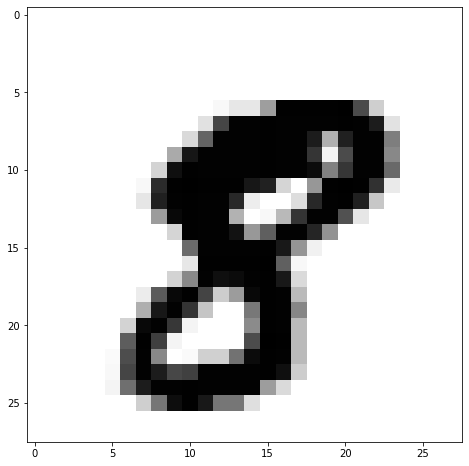

In [8]:
IMAGE_TO_DISPLAY = 10

# (784) => (28,28)
plt.imshow(images[IMAGE_TO_DISPLAY].reshape((28, 28)), cmap=cm.binary)

In [9]:
labels_flat = train_data.iloc[:,0].values

print('labels_flat({0})'.format(len(labels_flat)))
print ('labels_flat[{0}] => {1}'.format(IMAGE_TO_DISPLAY,labels_flat[IMAGE_TO_DISPLAY]))

labels_flat(42000)
labels_flat[10] => 8


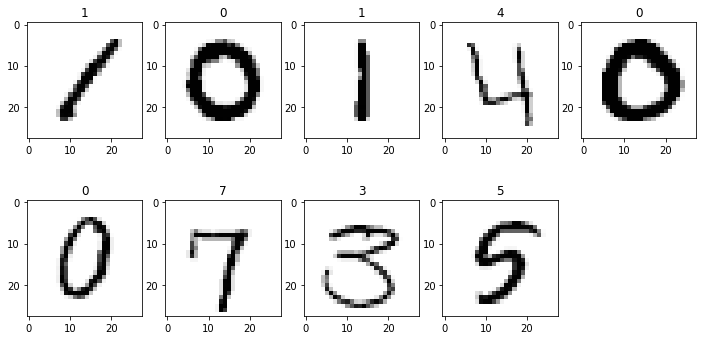

In [10]:
plt.figure(figsize=(12,6))
for i in range(0,9):
    plt.subplot(250 + (i+1))
    img = images[i,:].reshape(28, 28)
    plt.imshow(img, cmap='Greys')
    plt.title(labels_flat[i])

In [11]:
labels_count = np.unique(labels_flat).shape[0]

print('labels_count => {0}'.format(labels_count))

labels_count => 10


In [12]:
test_data.head()

,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [13]:
test_images = test_data.values.astype(np.float)
test_images.shape

/tmp/ipykernel_148044/452806879.py:1: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  test_images = test_data.values.astype(np.float)


(28000, 784)

In [14]:
X_train, X_test, y_train, y_test = model_selection.train_test_split(images, 
                                                                    labels_flat, 
                                                                    test_size=0.4, 
                                                                    random_state=0)
print('train images({0[0]},{0[1]})'.format(X_train.shape))
print('validation images({0[0]},{0[1]})'.format(X_test.shape))
print('train labels({})'.format(y_train.shape))
print('validation labels({})'.format(y_test.shape))

train images(25200,784)
validation images(16800,784)
train labels((25200,))
validation labels((16800,))


In [15]:
from sklearn.ensemble import RandomForestClassifier

# create and train the random forest
# multi-core CPUs can use: rf = RandomForestClassifier(n_estimators=100, n_jobs=2)
clf_rf = RandomForestClassifier(n_estimators=300, 
                                criterion='gini', 
                                max_depth=None, 
                                min_samples_split=3, 
                                min_samples_leaf=1, 
                                min_weight_fraction_leaf=0.0, 
                                max_features='auto', 
                                max_leaf_nodes=None, 
                                bootstrap=True, 
                                oob_score=False, 
                                n_jobs=-1, 
                                random_state=0, 
                                verbose=0, 
                                warm_start=False, 
                                class_weight=None).fit(X_train, y_train)

eval_rf = clf_rf.score(X_test, y_test)
print(eval_rf)

0.9611904761904762


In [16]:
# Train SVM...
from sklearn import svm
#http://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html

clf_svm = svm.SVC(kernel='poly',
                  C=1.57,
                  degree=2, 
                  gamma=0.278,
                  coef0=0.0, 
                  shrinking=True, 
                  probability=False, 
                  tol=0.001, 
                  cache_size=200, 
                  class_weight=None, 
                  verbose=False, 
                  max_iter=-1, 
                  random_state=0).fit(X_train, y_train)

eval_svm = clf_svm.score(X_test, y_test)
print(eval_svm)

0.9720833333333333


Making Predictions

In [17]:
predict_rf = clf_rf.predict(test_images)
predict_rf[0:10]

array([2, 0, 9, 9, 3, 7, 0, 3, 0, 3])

In [18]:
predict_svm = clf_svm.predict(test_images)
predict_svm[0:10]

array([2, 0, 9, 0, 3, 7, 0, 3, 0, 3])

### Using Tensor Flow (with a fully connected ANN)

In [19]:
import tensorflow as tf
print(tf.__version__)

mnist = tf.keras.datasets.mnist

(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train, x_test = x_train / 255.0, x_test / 255.0

2.8.0


Train: X=(60000, 28, 28), y=(60000,)
Test: X=(10000, 28, 28), y=(10000,)


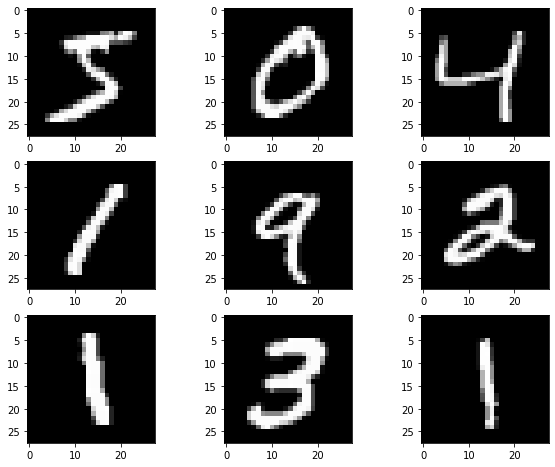

In [20]:
# summarize loaded dataset
print('Train: X=%s, y=%s' % (x_train.shape, y_train.shape))
print('Test: X=%s, y=%s' % (x_test.shape, y_test.shape))
# plot first few images
for i in range(9):
    # define subplot
    plt.subplot(330 + 1 + i)
    # plot raw pixel data
    plt.imshow(x_train[i], cmap=plt.get_cmap('gray'))
# show the figure
plt.show()

In [21]:
model = tf.keras.models.Sequential([tf.keras.layers.Flatten(input_shape=(28, 28)),
                                    tf.keras.layers.Dense(128, activation='relu'),
                                    tf.keras.layers.Dropout(0.2),
                                    tf.keras.layers.Dense(10, activation='softmax')
                                   ])

model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 784)               0         
                                                                 
 dense (Dense)               (None, 128)               100480    
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 10)                1290      
                                                                 
Total params: 101,770
Trainable params: 101,770
Non-trainable params: 0
_________________________________________________________________


2022-02-12 01:47:38.783839: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-02-12 01:47:38.784295: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-02-12 01:47:38.784346: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublas.so.11'; dlerror: libcublas.so.11: cannot open shared object file: No such file or directory
2022-02-12 01:47:38.784393: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublasLt.so.11'; dlerror: libcublasLt.so.11: cannot open shared object file: No such file or directory
2022-02-12 01:47:38.784437: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Co

In [22]:
%time model.fit(x_train, y_train, epochs=10)
model.evaluate(x_test,  y_test, verbose=1)

Epoch 1/10


2022-02-12 01:47:38.991058: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 188160000 exceeds 10% of free system memory.


1875/1875 [==============================] - 3s 1ms/step - loss: 0.2968 - accuracy: 0.9135
Epoch 2/10
1875/1875 [==============================] - 3s 1ms/step - loss: 0.1404 - accuracy: 0.9578
Epoch 3/10
1875/1875 [==============================] - 3s 1ms/step - loss: 0.1063 - accuracy: 0.9673
Epoch 4/10
1875/1875 [==============================] - 3s 1ms/step - loss: 0.0872 - accuracy: 0.9727
Epoch 5/10
1875/1875 [==============================] - 3s 1ms/step - loss: 0.0724 - accuracy: 0.9774
Epoch 6/10
1875/1875 [==============================] - 3s 1ms/step - loss: 0.0653 - accuracy: 0.9793
Epoch 7/10
1875/1875 [==============================] - 3s 1ms/step - loss: 0.0557 - accuracy: 0.9820
Epoch 8/10
1875/1875 [==============================] - 3s 1ms/step - loss: 0.0517 - accuracy: 0.9834
Epoch 9/10
1875/1875 [==============================] - 3s 1ms/step - loss: 0.0478 - accuracy: 0.9843
Epoch 10/10
1875/1875 [==============================] - 3s 1ms/step - loss: 0.0425 - accurac

2022-02-12 01:48:05.203605: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 31360000 exceeds 10% of free system memory.


313/313 [==============================] - 0s 955us/step - loss: 0.0763 - accuracy: 0.9776


[0.07630892097949982, 0.9775999784469604]

### Using Tensor Flow (with a CNN)

### a) simple model

In [23]:
def prep_pixels(train, test):
    # convert from integers to floats
    train_norm = train.astype('float32')
    test_norm = test.astype('float32')
    # normalize to range 0-1
    train_norm = train_norm / 255.0
    test_norm = test_norm / 255.0
    # return normalized images
    return train_norm, test_norm

# baseline cnn model for mnist

(trainX, trainY), (testX, testY) = mnist.load_data()
# reshape dataset to have a single channel
trainX = trainX.reshape((trainX.shape[0], 28, 28, 1))
testX = testX.reshape((testX.shape[0], 28, 28, 1))
# one hot encode target values
trainY = tf.keras.utils.to_categorical(trainY)
testY = tf.keras.utils.to_categorical(testY)
# scale pixels
trainX, testX = prep_pixels(trainX, testX)



model = tf.keras.models.Sequential([tf.keras.layers.Conv2D(32, 
                                                           kernel_size=(3, 3), 
                                                           activation='relu', 
                                                           kernel_initializer='he_uniform', 
                                                           input_shape=(28, 28, 1)),
                                    tf.keras.layers.MaxPooling2D((2, 2)),
                                    tf.keras.layers.Flatten(),
                                    tf.keras.layers.Dense(100, activation='relu', kernel_initializer='he_uniform'),
                                    tf.keras.layers.Dense(10, activation='softmax'),
                                   ])

model.compile(optimizer='adam', #SGD(lr=0.01, momentum=0.9)
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 26, 26, 32)        320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 13, 13, 32)       0         
 )                                                               
                                                                 
 flatten_1 (Flatten)         (None, 5408)              0         
                                                                 
 dense_2 (Dense)             (None, 100)               540900    
                                                                 
 dense_3 (Dense)             (None, 10)                1010      
                                                                 
Total params: 542,230
Trainable params: 542,230
Non-trainable params: 0
________________________________________________

In [24]:
%time model.fit(trainX, trainY, epochs=10)
model.evaluate(testX, testY, verbose=1)

Epoch 1/10


2022-02-12 01:48:06.242589: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 188160000 exceeds 10% of free system memory.


1875/1875 [==============================] - 15s 8ms/step - loss: 0.1335 - accuracy: 0.9595
Epoch 2/10
1875/1875 [==============================] - 15s 8ms/step - loss: 0.0459 - accuracy: 0.9858
Epoch 3/10
1875/1875 [==============================] - 15s 8ms/step - loss: 0.0279 - accuracy: 0.9908
Epoch 4/10
1875/1875 [==============================] - 15s 8ms/step - loss: 0.0181 - accuracy: 0.9941
Epoch 5/10
1875/1875 [==============================] - 15s 8ms/step - loss: 0.0133 - accuracy: 0.9954
Epoch 6/10
1875/1875 [==============================] - 16s 8ms/step - loss: 0.0098 - accuracy: 0.9968
Epoch 7/10
1875/1875 [==============================] - 15s 8ms/step - loss: 0.0059 - accuracy: 0.9981
Epoch 8/10
1875/1875 [==============================] - 15s 8ms/step - loss: 0.0077 - accuracy: 0.9974
Epoch 9/10
1875/1875 [==============================] - 15s 8ms/step - loss: 0.0052 - accuracy: 0.9982
Epoch 10/10
1875/1875 [==============================] - 14s 7ms/step - loss: 0.0043

[0.055690497159957886, 0.9865999817848206]

### b) slightly bigger model

In [25]:
from tensorflow.keras.callbacks import EarlyStopping

In [26]:
model = tf.keras.Sequential()
model.add(tf.keras.layers.Conv2D(32, 
                                 kernel_size=(3, 3),
                                 activation='relu',
                                 kernel_initializer='he_uniform',
                                 input_shape=(28, 28, 1)
                                ))
model.add(tf.keras.layers.Conv2D(64, (3, 3), activation='relu'))
model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))
model.add(tf.keras.layers.Dropout(0.25))
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(128, activation='relu'))
model.add(tf.keras.layers.Dropout(0.5))
model.add(tf.keras.layers.Dense(10, activation='softmax'))

model.compile(optimizer='adam', #tf.keras.optimizers.SGD(lr=0.01, momentum=0.9)
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_1 (Conv2D)           (None, 26, 26, 32)        320       
                                                                 
 conv2d_2 (Conv2D)           (None, 24, 24, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 12, 12, 64)       0         
 2D)                                                             
                                                                 
 dropout_1 (Dropout)         (None, 12, 12, 64)        0         
                                                                 
 flatten_2 (Flatten)         (None, 9216)              0         
                                                                 
 dense_4 (Dense)             (None, 128)               1179776   
                                                      

In [27]:
early_stopping = EarlyStopping(monitor='val_loss', patience=3)

%time history = model.fit(trainX, trainY,batch_size=32, epochs=10, verbose=1, \
                          validation_data=(testX, testY), callbacks=[early_stopping])
model.evaluate(testX, testY, verbose=1)

Epoch 1/10


2022-02-12 01:50:37.729045: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 188160000 exceeds 10% of free system memory.


   5/1875 [..............................] - ETA: 1:02 - loss: 2.2106 - accuracy: 0.2250

2022-02-12 01:50:38.229969: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 23887872 exceeds 10% of free system memory.


1875/1875 [==============================] - 61s 32ms/step - loss: 0.1853 - accuracy: 0.9432 - val_loss: 0.0474 - val_accuracy: 0.9848
Epoch 2/10
1875/1875 [==============================] - 61s 33ms/step - loss: 0.0795 - accuracy: 0.9761 - val_loss: 0.0382 - val_accuracy: 0.9867
Epoch 3/10
1875/1875 [==============================] - 59s 31ms/step - loss: 0.0609 - accuracy: 0.9818 - val_loss: 0.0351 - val_accuracy: 0.9883
Epoch 4/10
1875/1875 [==============================] - 59s 31ms/step - loss: 0.0485 - accuracy: 0.9849 - val_loss: 0.0344 - val_accuracy: 0.9893
Epoch 5/10
1875/1875 [==============================] - 61s 32ms/step - loss: 0.0429 - accuracy: 0.9867 - val_loss: 0.0297 - val_accuracy: 0.9904
Epoch 6/10
1875/1875 [==============================] - 60s 32ms/step - loss: 0.0354 - accuracy: 0.9890 - val_loss: 0.0303 - val_accuracy: 0.9915
Epoch 7/10
1875/1875 [==============================] - 59s 32ms/step - loss: 0.0328 - accuracy: 0.9895 - val_loss: 0.0322 - val_accura

[0.033081233501434326, 0.9908000230789185]

In [28]:
score = model.evaluate(testX, testY, verbose=1)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

313/313 [==============================] - 2s 7ms/step - loss: 0.0331 - accuracy: 0.9908
Test loss: 0.033081233501434326
Test accuracy: 0.9908000230789185


In [29]:
hist_df = pd.DataFrame(history.history)
hist_df.head()

,loss,accuracy,val_loss,val_accuracy
0,0.185317,0.943167,0.047405,0.9848
1,0.079479,0.976067,0.038220,0.9867
2,0.060913,0.981800,0.035064,0.9883
3,0.048478,0.984917,0.034388,0.9893
4,0.042873,0.986667,0.029731,0.9904


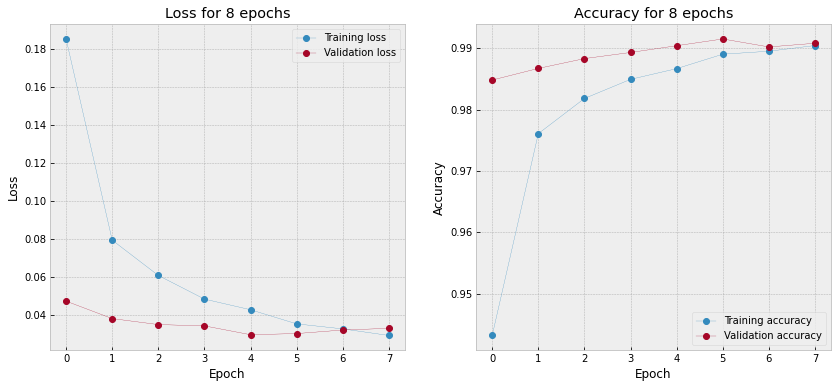

In [30]:
fig = plt.figure(figsize=(14,6))
plt.style.use('bmh')
params_dict = dict(linestyle='solid', linewidth=0.25, marker='o', markersize=6)

plt.subplot(121)
plt.plot(hist_df.loss, label='Training loss', **params_dict)
plt.plot(hist_df.val_loss, label='Validation loss', **params_dict)
plt.title('Loss for ' + str(len(history.epoch)) + ' epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(122)
plt.plot(hist_df.accuracy, label='Training accuracy', **params_dict)
plt.plot(hist_df.val_accuracy, label='Validation accuracy', **params_dict)
plt.title('Accuracy for ' + str(len(history.epoch)) + ' epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

### c) [Using the LENET architecture](https://www.pyimagesearch.com/2016/08/01/lenet-convolutional-neural-network-in-python/  )

![](../../../images/lenet_architecture-768x226.png)

The LeNet architecture was first introduced by LeCun et al. in their 1998 paper, Gradient-Based Learning Applied to Document Recognition. As the name of the paper suggests, the authors’ implementation of LeNet was used primarily for OCR and character recognition in documents.  

The LeNet architecture is straightforward and small, (in terms of memory footprint), making it perfect for teaching the basics of CNNs — it can even run on the CPU (if your system does not have a suitable GPU), making it a great “first CNN”.  

However, if you do have GPU support and can access your GPU via Keras, you will enjoy extremely fast training times (in the order of 3-10 seconds per epoch, depending on your GPU).  

In [31]:
model = tf.keras.Sequential()
model.add(tf.keras.layers.Convolution2D(filters=20, kernel_size = (5, 5), padding = "same", input_shape = (28, 28, 1)))
model.add(tf.keras.layers.Activation(activation="relu"))
model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2), strides =  (2, 2)))
model.add(tf.keras.layers.Convolution2D(filters=50, kernel_size = (5, 5), padding = "same"))
model.add(tf.keras.layers.Activation(activation= "relu"))
model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2), strides = (2, 2)))
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(500))
model.add(tf.keras.layers.Activation(activation = "relu"))
model.add(tf.keras.layers.Dense(10))
model.add(tf.keras.layers.Activation("softmax"))

model.summary()

model.compile(optimizer='adam', #tf.keras.optimizers.SGD(lr=0.01, momentum=0.9)
              loss='categorical_crossentropy',
              metrics=['accuracy'])

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 28, 28, 20)        520       
                                                                 
 activation (Activation)     (None, 28, 28, 20)        0         
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 14, 14, 20)       0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 14, 14, 50)        25050     
                                                                 
 activation_1 (Activation)   (None, 14, 14, 50)        0         
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 7, 7, 50)         0         
 2D)                                                  

In [32]:
early_stopping = EarlyStopping(monitor='val_loss', patience=3)

%time history = model.fit(trainX, trainY, batch_size=32, epochs=10, verbose=1, \
                          validation_data=(testX, testY), callbacks=[early_stopping])

model.evaluate(testX, testY, verbose=1)

Epoch 1/10
1875/1875 [==============================] - 44s 23ms/step - loss: 0.1088 - accuracy: 0.9664 - val_loss: 0.0373 - val_accuracy: 0.9886
Epoch 2/10
1875/1875 [==============================] - 37s 20ms/step - loss: 0.0381 - accuracy: 0.9882 - val_loss: 0.0254 - val_accuracy: 0.9909
Epoch 3/10
1875/1875 [==============================] - 37s 20ms/step - loss: 0.0258 - accuracy: 0.9921 - val_loss: 0.0305 - val_accuracy: 0.9901
Epoch 4/10
1875/1875 [==============================] - 37s 20ms/step - loss: 0.0187 - accuracy: 0.9938 - val_loss: 0.0446 - val_accuracy: 0.9861
Epoch 5/10
1875/1875 [==============================] - 36s 19ms/step - loss: 0.0134 - accuracy: 0.9958 - val_loss: 0.0319 - val_accuracy: 0.9887
CPU times: user 16min 14s, sys: 17.5 s, total: 16min 32s
Wall time: 3min 10s
313/313 [==============================] - 2s 5ms/step - loss: 0.0319 - accuracy: 0.9887


[0.031866997480392456, 0.9886999726295471]

In [33]:
score = model.evaluate(testX, testY, verbose=1)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

313/313 [==============================] - 2s 5ms/step - loss: 0.0319 - accuracy: 0.9887
Test loss: 0.031866997480392456
Test accuracy: 0.9886999726295471


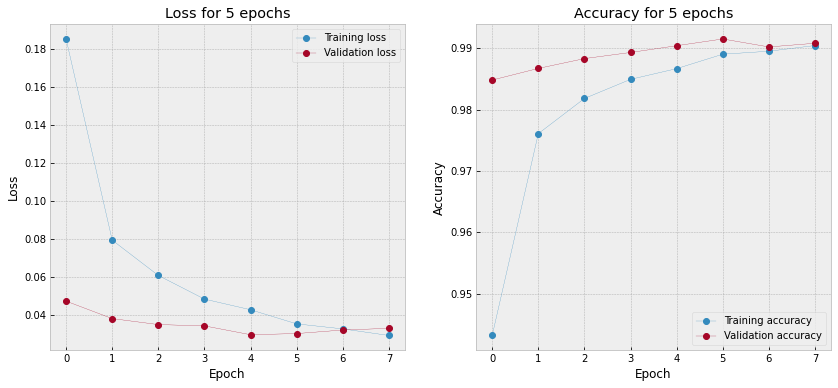

In [34]:
fig = plt.figure(figsize=(14,6))
plt.style.use('bmh')
params_dict = dict(linestyle='solid', linewidth=0.25, marker='o', markersize=6)

plt.subplot(121)
plt.plot(hist_df.loss, label='Training loss', **params_dict)
plt.plot(hist_df.val_loss, label='Validation loss', **params_dict)
plt.title('Loss for ' + str(len(history.epoch)) + ' epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(122)
plt.plot(hist_df.accuracy, label='Training accuracy', **params_dict)
plt.plot(hist_df.val_accuracy, label='Validation accuracy', **params_dict)
plt.title('Accuracy for ' + str(len(history.epoch)) + ' epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

### d) Testing a more complex model

![](https://sihamtabik.github.io/LeNet-like-CNN.jpg)

In [35]:
nb_filters_1 = 32 # 64
nb_filters_2 = 64 # 128
nb_filters_3 = 128 # 256
nb_conv = 3

model = tf.keras.Sequential()
model.add(tf.keras.layers.ZeroPadding2D((1,1), input_shape=(28, 28, 1),))
model.add(tf.keras.layers.Conv2D(nb_filters_1, (nb_conv, nb_conv),  activation="relu"))
model.add(tf.keras.layers.ZeroPadding2D((1, 1)))
model.add(tf.keras.layers.Conv2D(nb_filters_1, (nb_conv, nb_conv), activation="relu"))
model.add(tf.keras.layers.MaxPooling2D(strides=(2,2)))
model.add(tf.keras.layers.ZeroPadding2D((1, 1)))
model.add(tf.keras.layers.Conv2D(nb_filters_2, (nb_conv, nb_conv), activation="relu"))
model.add(tf.keras.layers.ZeroPadding2D((1, 1)))
model.add(tf.keras.layers.Conv2D(nb_filters_2, (nb_conv, nb_conv), activation="relu"))
model.add(tf.keras.layers.MaxPooling2D(strides=(2,2)))
model.add(tf.keras.layers.ZeroPadding2D((1, 1)))
model.add(tf.keras.layers.Conv2D(nb_filters_3, (nb_conv, nb_conv), activation="relu"))
model.add(tf.keras.layers.ZeroPadding2D((1, 1)))
model.add(tf.keras.layers.Conv2D(nb_filters_3, (nb_conv, nb_conv), activation="relu"))
model.add(tf.keras.layers.ZeroPadding2D((1, 1)))
model.add(tf.keras.layers.Conv2D(nb_filters_3, (nb_conv, nb_conv), activation="relu"))
model.add(tf.keras.layers.ZeroPadding2D((1, 1)))
model.add(tf.keras.layers.Conv2D(nb_filters_3, (nb_conv, nb_conv), activation="relu"))
model.add(tf.keras.layers.MaxPooling2D(strides=(2,2)))
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dropout(0.2))
model.add(tf.keras.layers.Dense(128, activation="relu"))
model.add(tf.keras.layers.Dense(10, activation="softmax"))

model.summary()

model.compile(optimizer='adam', #tf.keras.optimizers.SGD(lr=0.01, momentum=0.9)
              loss='categorical_crossentropy',
              metrics=['accuracy'])

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 zero_padding2d (ZeroPadding  (None, 30, 30, 1)        0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 28, 28, 32)        320       
                                                                 
 zero_padding2d_1 (ZeroPaddi  (None, 30, 30, 32)       0         
 ng2D)                                                           
                                                                 
 conv2d_6 (Conv2D)           (None, 28, 28, 32)        9248      
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 14, 14, 32)       0         
 2D)                                                             
                                                      

In [36]:
early_stopping = EarlyStopping(monitor='val_loss', patience=3)

%time history = model.fit(trainX, trainY, batch_size=32, epochs=10, verbose=1, \
                          validation_data=(testX, testY), callbacks=[early_stopping])
model.evaluate(testX, testY, verbose=1)

Epoch 1/10
1875/1875 [==============================] - 140s 74ms/step - loss: 0.1797 - accuracy: 0.9419 - val_loss: 0.0549 - val_accuracy: 0.9846
Epoch 2/10
1875/1875 [==============================] - 145s 78ms/step - loss: 0.0545 - accuracy: 0.9838 - val_loss: 0.0403 - val_accuracy: 0.9877
Epoch 3/10
1875/1875 [==============================] - 141s 75ms/step - loss: 0.0418 - accuracy: 0.9874 - val_loss: 0.0314 - val_accuracy: 0.9904
Epoch 4/10
1875/1875 [==============================] - 141s 75ms/step - loss: 0.0337 - accuracy: 0.9898 - val_loss: 0.0277 - val_accuracy: 0.9917
Epoch 5/10
1875/1875 [==============================] - 141s 75ms/step - loss: 0.0292 - accuracy: 0.9915 - val_loss: 0.0290 - val_accuracy: 0.9923
Epoch 6/10
1875/1875 [==============================] - 144s 77ms/step - loss: 0.0263 - accuracy: 0.9924 - val_loss: 0.0348 - val_accuracy: 0.9900
Epoch 7/10
1875/1875 [==============================] - 143s 76ms/step - loss: 0.0244 - accuracy: 0.9930 - val_loss: 0

[0.036843132227659225, 0.9898999929428101]

In [37]:
score = model.evaluate(testX, testY, verbose=1)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

313/313 [==============================] - 6s 20ms/step - loss: 0.0368 - accuracy: 0.9899
Test loss: 0.036843132227659225
Test accuracy: 0.9898999929428101


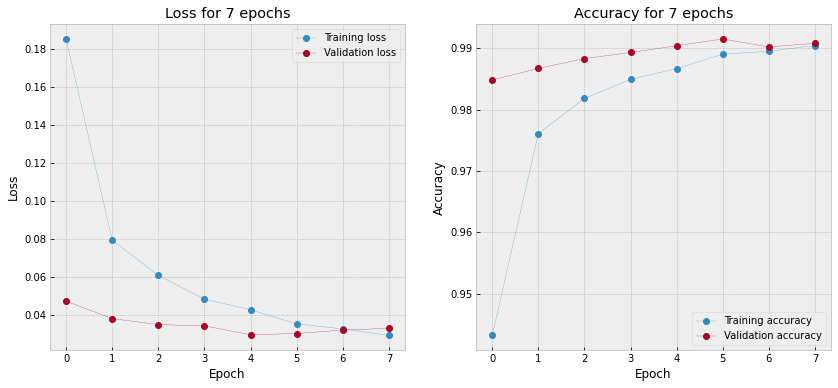

In [38]:
fig = plt.figure(figsize=(14,6))
plt.style.use('bmh')
params_dict = dict(linestyle='solid', linewidth=0.25, marker='o', markersize=6)

plt.subplot(121)
plt.plot(hist_df.loss, label='Training loss', **params_dict)
plt.plot(hist_df.val_loss, label='Validation loss', **params_dict)
plt.title('Loss for ' + str(len(history.epoch)) + ' epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(122)
plt.plot(hist_df.accuracy, label='Training accuracy', **params_dict)
plt.plot(hist_df.val_accuracy, label='Validation accuracy', **params_dict)
plt.title('Accuracy for ' + str(len(history.epoch)) + ' epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

#### Pre-trained models  

How can I use pre-trained models in Keras?  
Code and pre-trained weights are available for the following image classification models:  
+ Xception  
+ VGG16  
+ VGG19  
+ ResNet50  
+ Inception v3  

They can be imported from the module [keras.applications](https://keras.io/applications/):

In [39]:
#from keras.applications.xception import Xception
#from keras.applications.vgg16 import VGG16
#from keras.applications.vgg19 import VGG19
#from keras.applications.resnet50 import ResNet50
#from keras.applications.inception_v3 import InceptionV3

#model = VGG16(weights='imagenet', include_top=True)

[Transfer Learning and Fine-Tuning](https://keras.io/guides/transfer_learning/)
[Visualizing the classification task:](http://scs.ryerson.ca/~aharley/vis/fc/)